# Cloud distribution in THAI simulations

In [1]:
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.offsetbox import AnchoredText

In [2]:
import aeolus.plot as aplt

In [3]:
# Local modules
import mypaths
from calc import (
    cloud_area_fraction,
    cloud_path_ice,
    cloud_path_liquid,
    cloud_path_total,
    extract_troposphere,
    integral,
    meridional_mean,
    spatial_mean,
    specific_humidity,
)
from commons import MODELS
from names import names
from plot_func import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    XLOCS,
    darr_stats_string,
    draw_scalar,
    figsave,
    make_map_figure,
    set_alpha_in_cmap,
)

In [4]:
plt.style.use("paper.mplstyle")


Bad key legend.labelcolor in file paper.mplstyle, line 10 ('legend.labelcolor : linecolor')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution


## Choose case

In [5]:
THAI_cases = ["Hab1", "Hab2"]

## Load the data

Load the time-averaged data previously preprocessed.

In [6]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# for each of the THAI cases, create a nested directory for models
for THAI_case in THAI_cases:
    datasets[THAI_case] = {}
    for model_key in MODELS.keys():
        model_names = names[model_key]
        ds = xr.open_dataset(mypaths.datadir / model_key / f"{THAI_case}_time_mean_{model_key}.nc")
        if model_key in ["LMDG"]:
            lon_slice = slice(None, -1)  # omit the 180E longitude which is repeated
        else:
            lon_slice = slice(None, None)
        new_ds = {}
        for d in ds.data_vars:
            vrbl = ds[d]
            if model_names.x in ds[d].dims:
                vrbl = vrbl.isel(**{model_names.x: lon_slice})
            new_ds[d] = vrbl
        datasets[THAI_case][model_key] = xr.Dataset(new_ds)

In [7]:
TROP_LAPSE_THRESH = -2e-3

In [8]:
RESULTS = {}
for THAI_case in THAI_cases:
    RESULTS[THAI_case] = {}
    if THAI_case.endswith("1"):
        import const_ben1_hab1 as const
    else:
        import const_ben2_hab2 as const
    for model_key in MODELS.keys():
        RESULTS[THAI_case][model_key] = {}
        model_names = names[model_key]
        ds = datasets[THAI_case][model_key]

        if model_key == "ExoCAM":
            pres = ds[model_names.pres]
            alt = ds[model_names.z]
            kw_z = dict(
                coord=alt,
                dim=model_names.lev,
            )
        elif model_key == "LMDG":
            pres = ds[model_names.pres]
            alt = ds[model_names.lev]
            kw_z = dict(
                coord=alt,
                dim=model_names.z,
            )
        elif model_key == "ROCKE3D":
            pres = ds[model_names.pres] * 1e2
            alt = ds[model_names.z]
            kw_z = dict(
                coord=alt,
                dim=model_names.lev,
            )
        elif model_key == "UM":
            pres = ds[model_names.pres]
            alt = ds[model_names.z]
            kw_z = dict(dim=model_names.z)

        trop_mask = extract_troposphere(
            ds, model_key, lapse_thresh=TROP_LAPSE_THRESH, alt_thresh=8e3
        )

        rho = pres / (ds[model_names.temp] * const.rgas)
        rho = xr.where(trop_mask, rho, np.nan).dropna(kw_z["dim"])
        if "coord" in kw_z:
            kw_z["coord"] = xr.where(trop_mask, alt, np.nan).dropna(kw_z["dim"])
        # Mean tropospheric air temperature
        temp_trop = xr.where(trop_mask, ds[model_names.temp], np.nan).dropna(kw_z["dim"])
        RESULTS[THAI_case][model_key]["temp_trop_mean"] = integral(
            temp_trop * rho, **kw_z
        ) / integral(rho, **kw_z)

        # Water vapour path (vertical integral of specific humidity)
        RESULTS[THAI_case][model_key]["wvp"] = integral(
            specific_humidity(ds, model_key) * rho, **kw_z
        )

        # Cloud water paths
        RESULTS[THAI_case][model_key]["cwp"] = cloud_path_total(ds, model_key)
        RESULTS[THAI_case][model_key]["lwp"] = cloud_path_liquid(ds, model_key, const=const)
        RESULTS[THAI_case][model_key]["iwp"] = cloud_path_ice(ds, model_key, const=const)

        # Cloud fraction
        RESULTS[THAI_case][model_key]["caf"] = cloud_area_fraction(ds, model_key)


19579.44287235

18006.82237968

17405.16535345

19357.30311978

---

22623.62085212

19338.69300259

17439.5817311

16378.85828918

In [9]:
PLOT_SETTINGS = {
    "temp_trop_mean": {
        "tex_units": "$K$",
        "title": "Air temperature",
        "lim": {"Hab1": [230, 255], "Hab2": [250, 290]},
    },
    "wvp": {
        "tex_units": "$kg$ $m^{-2}$",
        "title": "Water vapor path",
        "lim": {"Hab1": [0, 150], "Hab2": [0, 150]},
    },
    "cwp": {
        "tex_units": "$kg$ $m^{-2}$",
        "title": "Cloud water path",
        "lim": {"Hab1": [0, 0.055], "Hab2": [0, 0.055]},
        "sub": {
            "cwp": dict(title="Total", kw_plt=dict(linestyle="-")),
            "lwp": dict(title="Liquid", kw_plt=dict(linestyle="--")),
            "iwp": dict(title="Ice", kw_plt=dict(linestyle=":")),
        },
    },
    "caf": {
        "tex_units": "%",
        "title": "Cloud area fraction",
        "lim": {"Hab1": [0, 100], "Hab2": [0, 100]},
    },
}

Saved to ../plots/Hab1__x__temp_trop_mean_wvp_cwp_caf.png
Saved to ../plots/Hab2__x__temp_trop_mean_wvp_cwp_caf.png


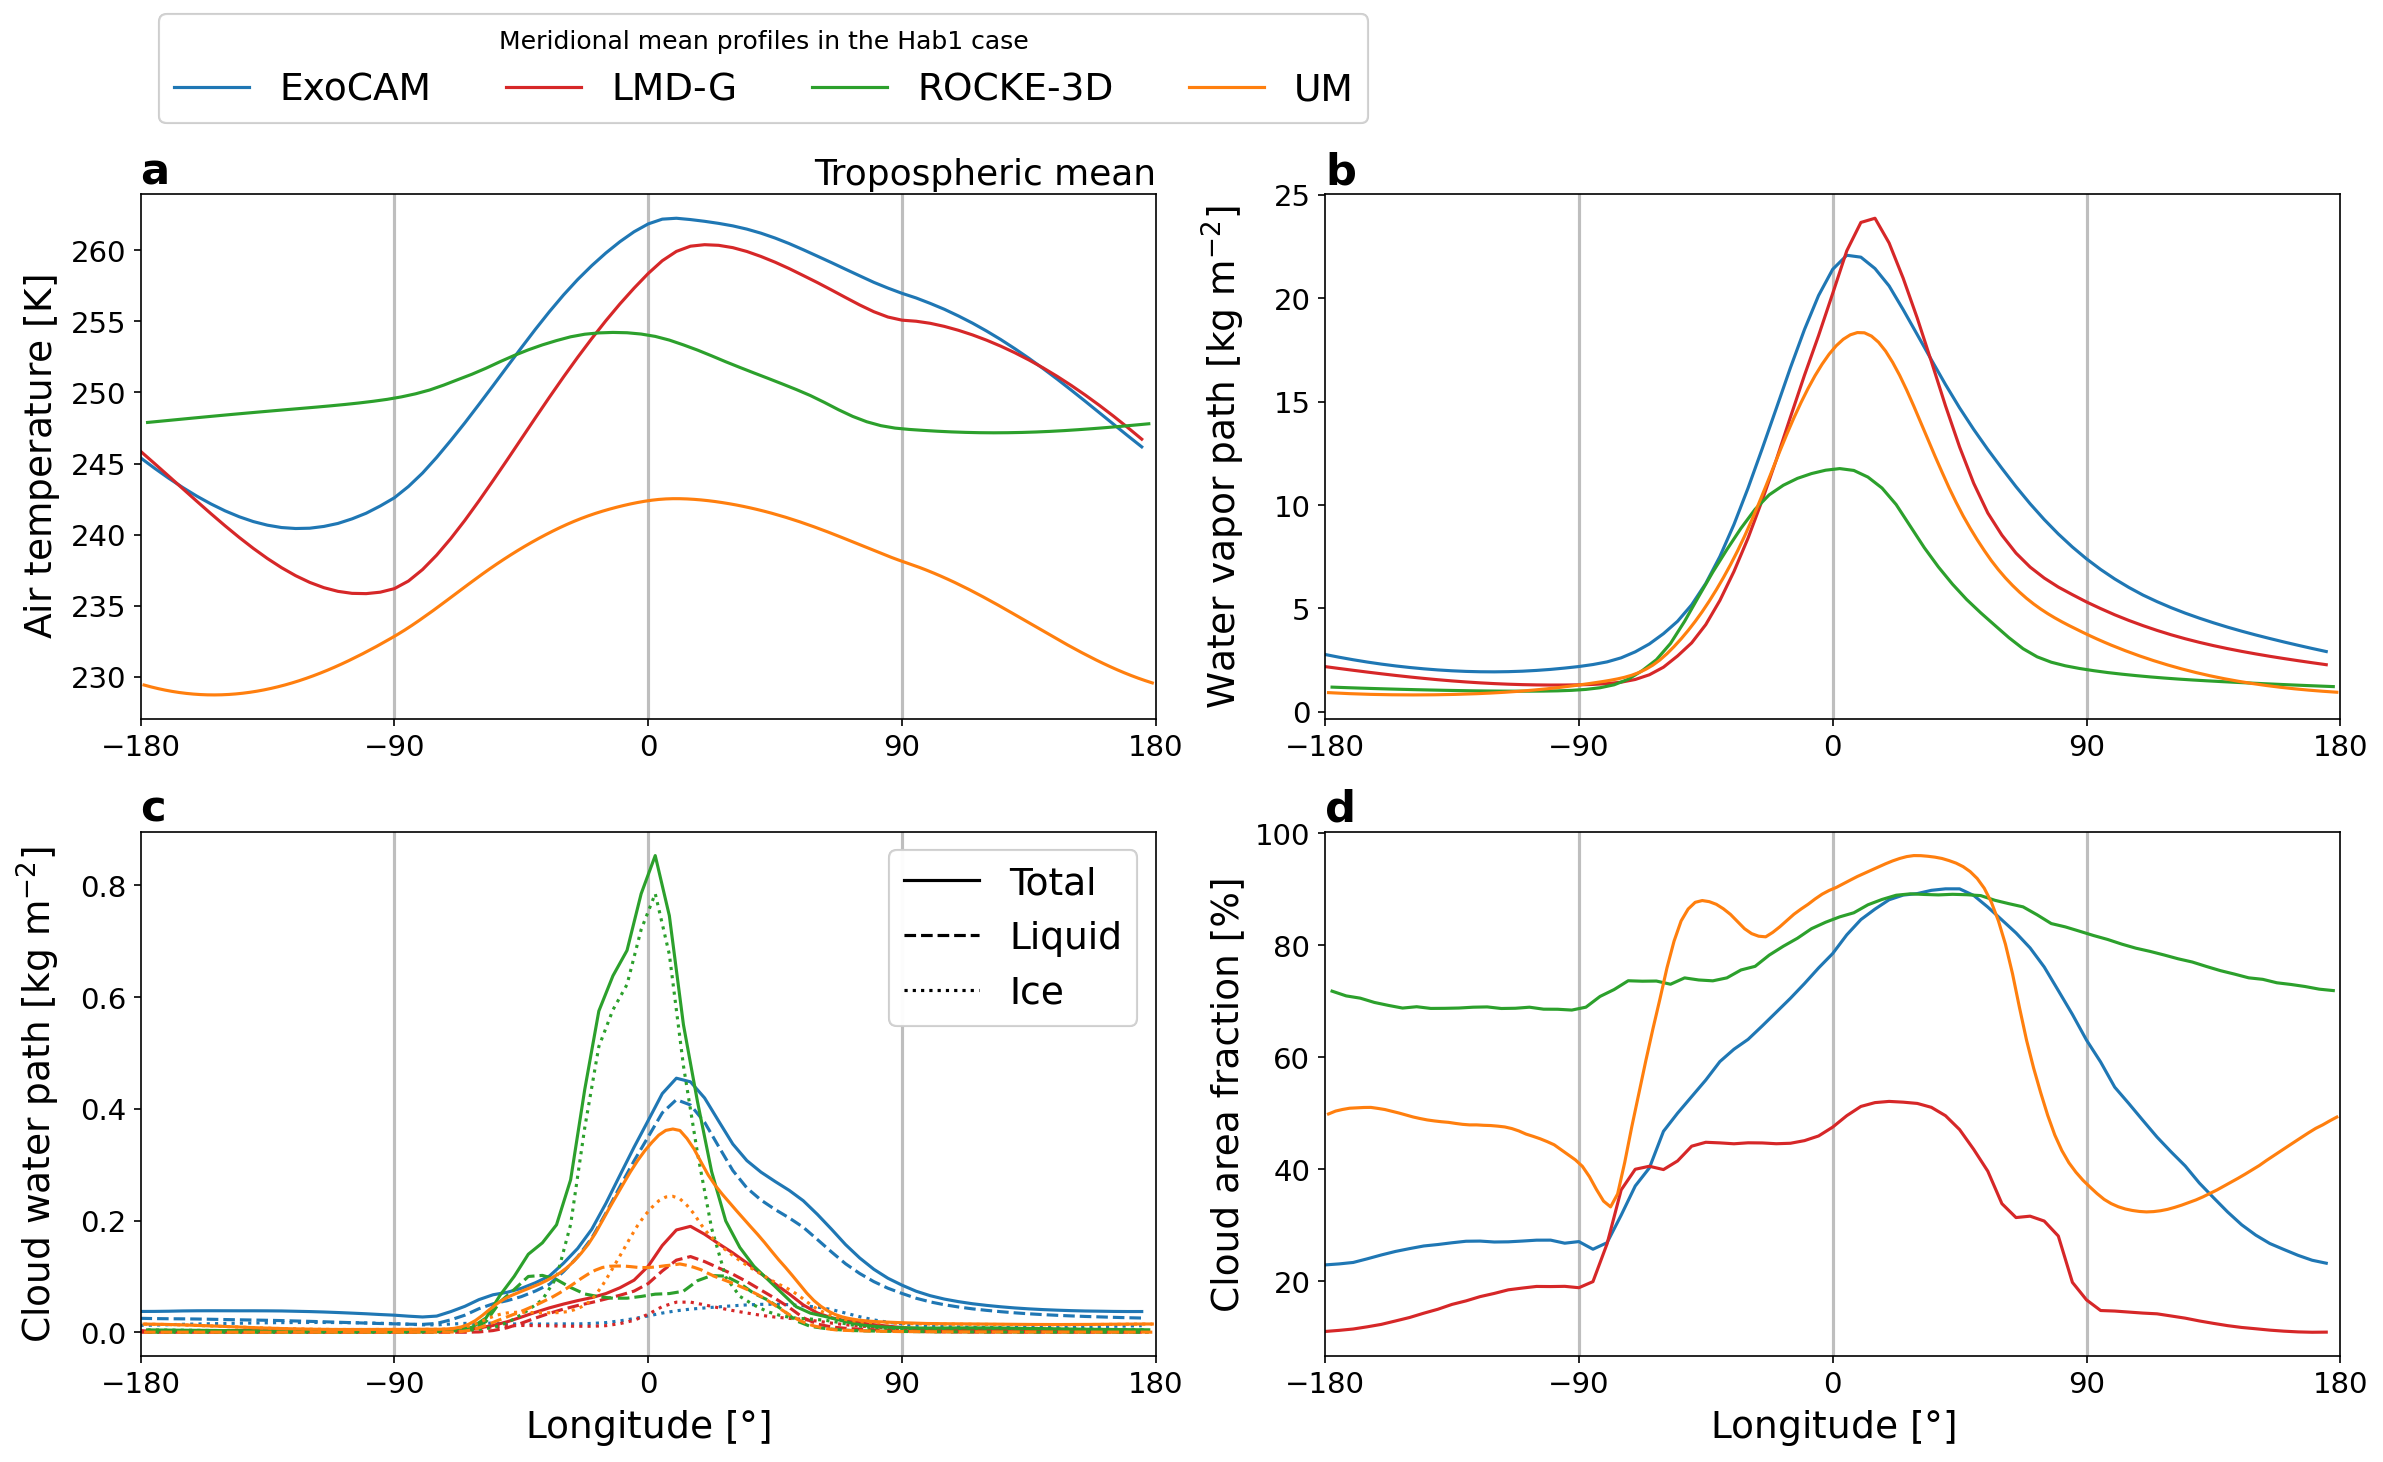

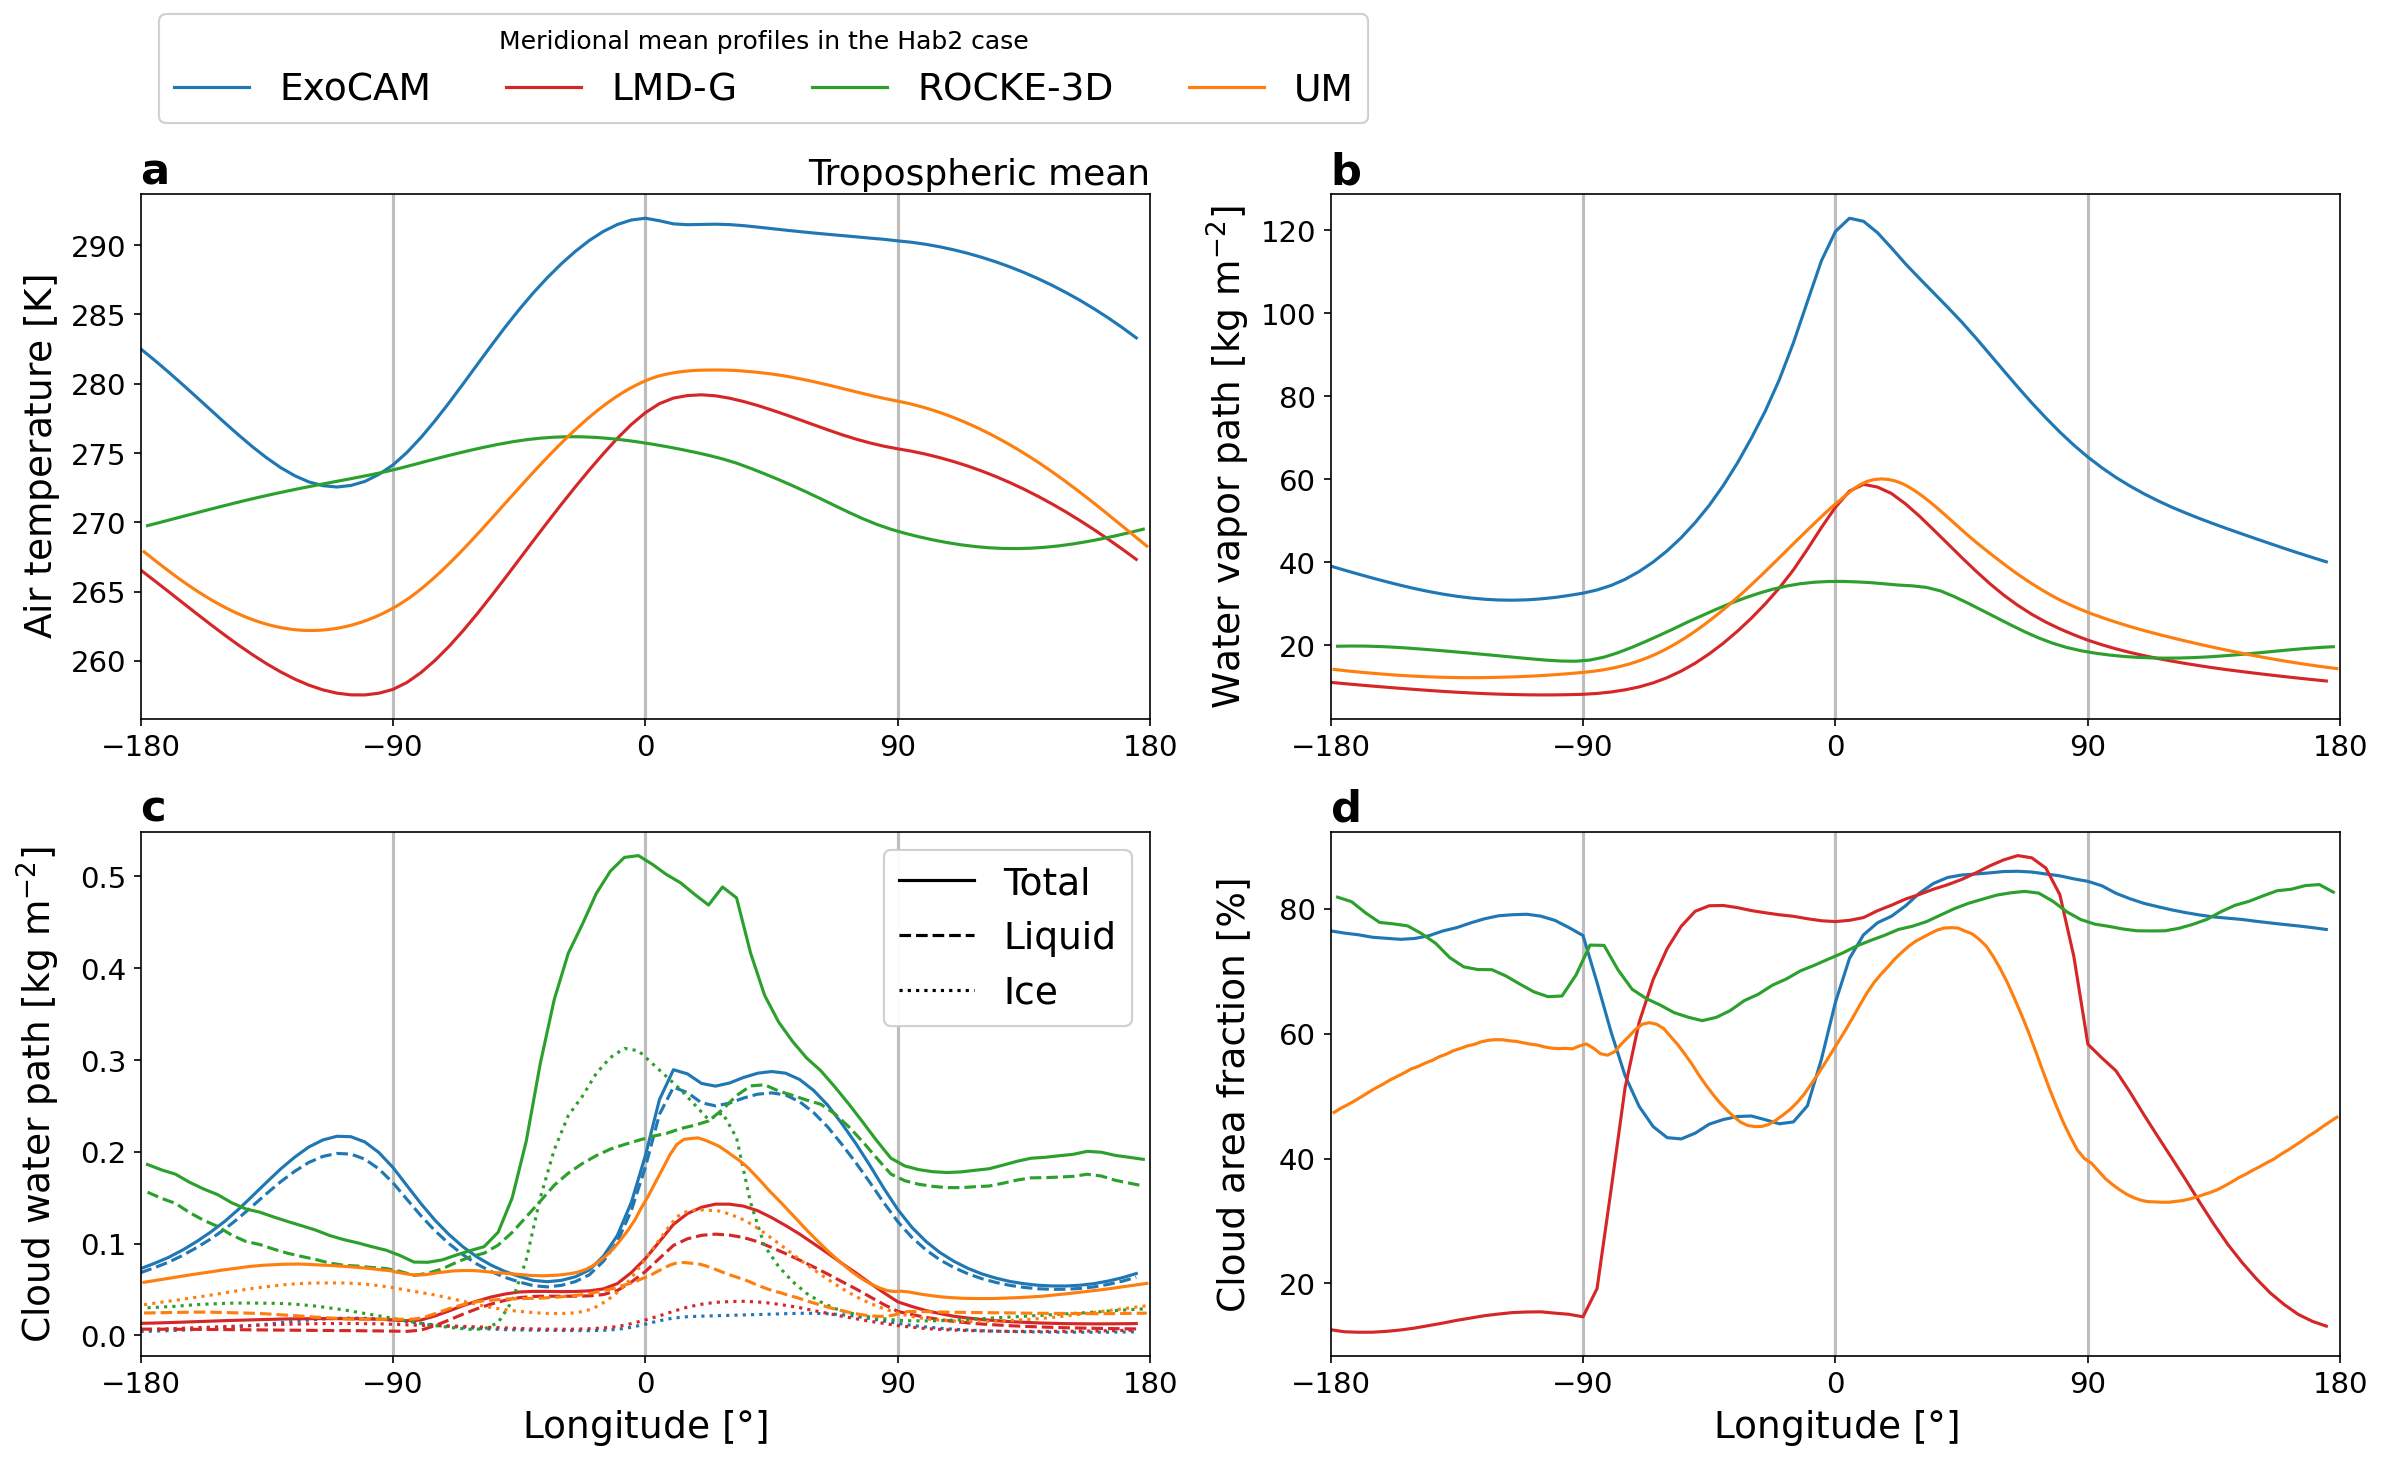

In [10]:
reduce = meridional_mean

for THAI_case in THAI_cases:
    fig = plt.figure(figsize=(2 * 8, 2 * 4.5))
    axs = fig.subplot_mosaic([["temp_trop_mean", "wvp"], ["cwp", "caf"]])
    iletters = aplt.subplot_label_generator()
    for ax in axs.values():
        ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
        ax.set_xticks(XLOCS)
        ax.set_xlim(XLOCS[0], XLOCS[-1])
        for ix in XLOCS[1:-1]:
            ax.axvline(ix, color="tab:grey", alpha=0.5)
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Longitude [$\degree$]")
    axs["temp_trop_mean"].set_title("Tropospheric mean", **KW_AUX_TTL)

    for model_key, model_dict in MODELS.items():
        model_names = names[model_key]
        for varkey, vardict in PLOT_SETTINGS.items():
            ax = axs[varkey]
            if "sub" in vardict:
                for subkey, subdict in vardict["sub"].items():
                    arr = reduce(RESULTS[THAI_case][model_key][subkey])
                    ax.plot(
                        arr[model_names.x],
                        arr,
                        color=model_dict["color"],
                        label=model_dict["title"],
                        **subdict["kw_plt"],
                    )
            else:
                arr = reduce(RESULTS[THAI_case][model_key][varkey])
                ax.plot(
                    arr[model_names.x],
                    arr,
                    color=model_dict["color"],
                    label=model_dict["title"],
                )
            # ax.set_ylim(vardict["lim"][THAI_case])
            ax.set_ylabel(f"{vardict['title']} [{vardict['tex_units']}]")

    ttl = f"Meridional mean profiles in the {THAI_case} case"
    aplt.add_custom_legend(
        axs["temp_trop_mean"],
        {md["title"]: dict(color=md["color"], linestyle="-") for md in MODELS.values()},
        # loc="upper left",
        title=ttl,
        ncol=len(MODELS),
        loc="lower left",
        bbox_to_anchor=(0, 1.1),
    )
    aplt.add_custom_legend(
        axs["cwp"],
        {v["title"]: {"color": "k", **v["kw_plt"]} for k, v in PLOT_SETTINGS["cwp"]["sub"].items()},
        loc="upper right",
    )

    fig.tight_layout()
    fig.align_labels()

    figsave(
        fig,
        mypaths.plotdir / f"{THAI_case}__x__{'_'.join(PLOT_SETTINGS.keys())}",
    )